# Проект "Промышленность"

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Цель проекта - построить модель, которая предскажет температуру стали. Подробнее - в README-файле.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Содержание**<a id='toc0_'></a>    
- 1. [Загрузка и изучение данных](#toc1_)    
- 2. [План работ по проекту](#toc2_)    
- 3. [Вопросы по процессу](#toc3_)    
- 4. [Предобработка данных](#toc4_)    
- 5. [Обучение моделей](#toc5_)    
- 6. [Тестирование модели](#toc6_)    
- 7. [Отчёт по решению](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

## 1. <a id='toc1_'></a>[Загрузка и изучение данных](#toc0_)

Все замечания по данным приведены в выводе по разделу



In [2]:
# данные об электродах
df_arc = pd.read_csv('datasets/data_arc_new.csv', parse_dates=[1, 2])

In [3]:
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [4]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [5]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [6]:
df_arc.iloc[:, [1, 2]].apply(lambda x: x.is_monotonic_increasing)

Начало нагрева дугой    True
Конец нагрева дугой     True
dtype: bool

In [7]:
df_arc.loc[df_arc.iloc[:, 4] < -2, :]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


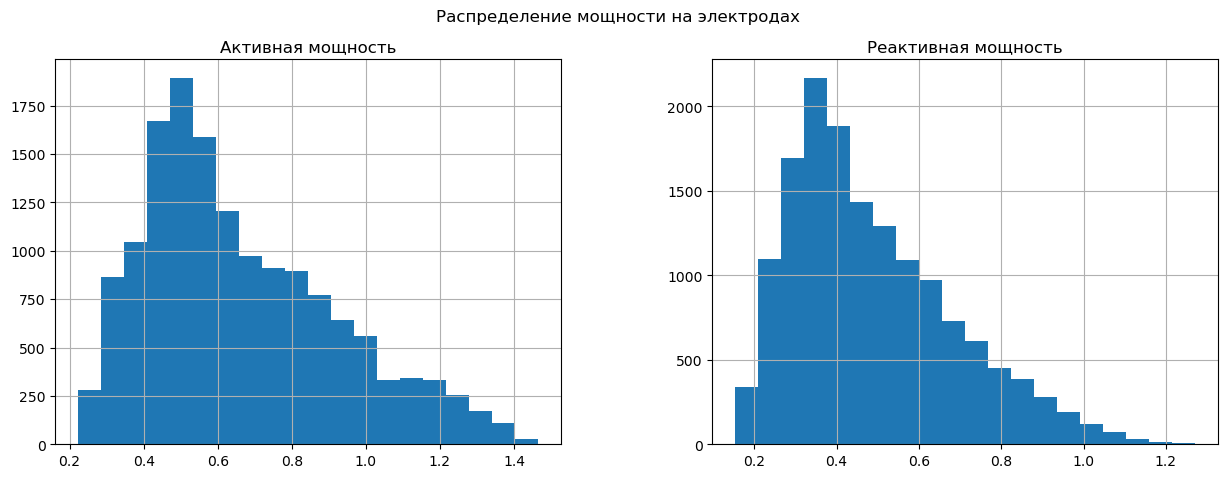

In [8]:
fig, ax = plt.subplots(figsize=(15,5), ncols=2)
df_arc.iloc[:, [3, 4]].drop(9780).hist(bins=20, ax=ax)
fig.suptitle('Распределение мощности на электродах');

In [9]:
# данные о подаче сыпучих материалов (объём)
df_bulk = pd.read_csv('datasets/data_bulk_new.csv', index_col=0)

In [10]:
df_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [11]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


In [12]:
df_bulk.describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


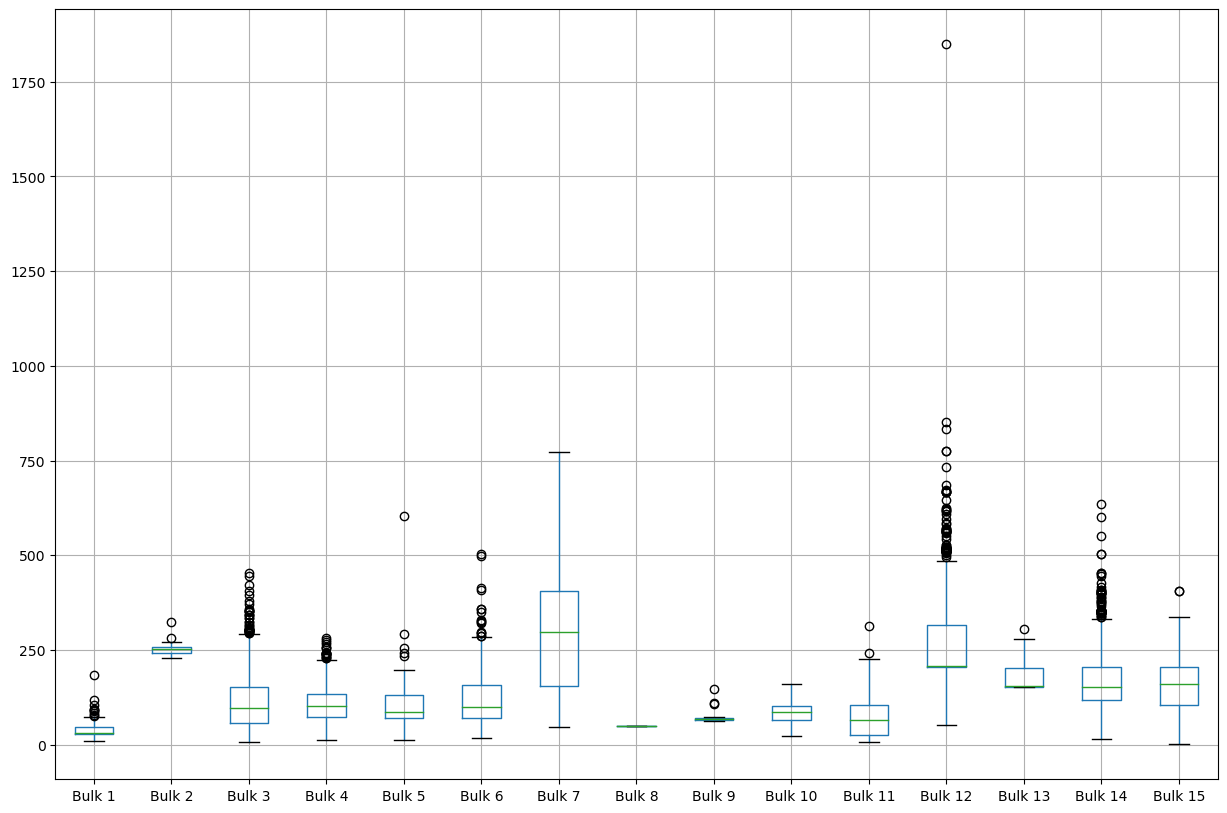

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
df_bulk.boxplot(ax=ax);

In [14]:
# данные о подаче сыпучих материалов (время)
df_bulk_time = pd.read_csv('datasets/data_bulk_time_new.csv', parse_dates=list(range(1, 16)), index_col=0)

In [15]:
df_bulk_time.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [16]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   252 non-null    datetime64[ns]
 1   Bulk 2   22 non-null     datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 7   25 non-null     datetime64[ns]
 7   Bulk 8   1 non-null      datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


In [17]:
df_bulk_time.describe(datetime_is_numeric=True)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15


In [18]:
df_bulk_time.apply(lambda x: x.dropna().is_monotonic_increasing)

Bulk 1     True
Bulk 2     True
Bulk 3     True
Bulk 4     True
Bulk 5     True
Bulk 6     True
Bulk 7     True
Bulk 8     True
Bulk 9     True
Bulk 10    True
Bulk 11    True
Bulk 12    True
Bulk 13    True
Bulk 14    True
Bulk 15    True
dtype: bool

In [19]:
# данные о продувке сплава газом
df_gas = pd.read_csv('datasets/data_gas_new.csv', index_col=0)

In [20]:
df_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [21]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


In [22]:
df_gas.describe()

,Газ 1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


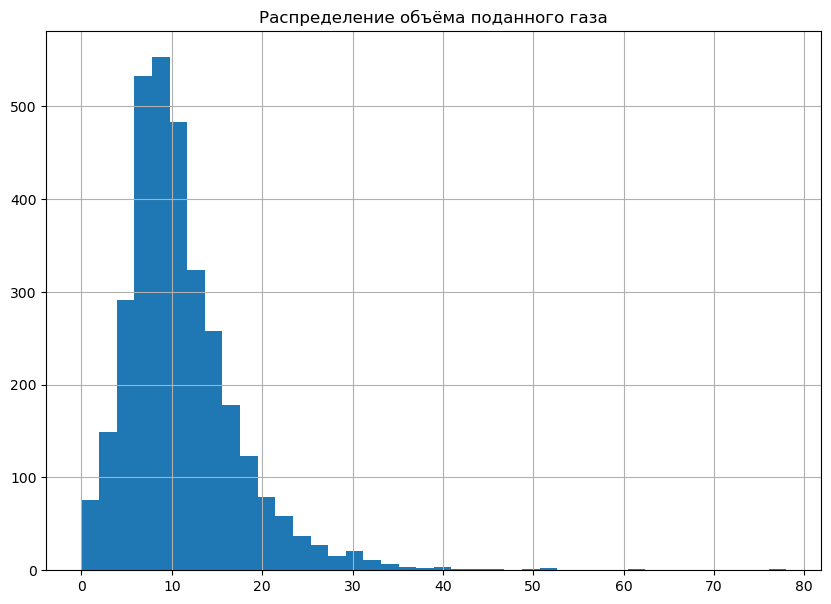

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
df_gas.hist(bins=40, ax=ax)
ax.set_title('Распределение объёма поданного газа');

In [24]:
# результаты измерения температуры
df_temp = pd.read_csv('datasets/data_temp_new.csv', parse_dates=[1])

In [25]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [26]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [27]:
df_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [28]:
df_temp[df_temp.iloc[:, 2] < 1500]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


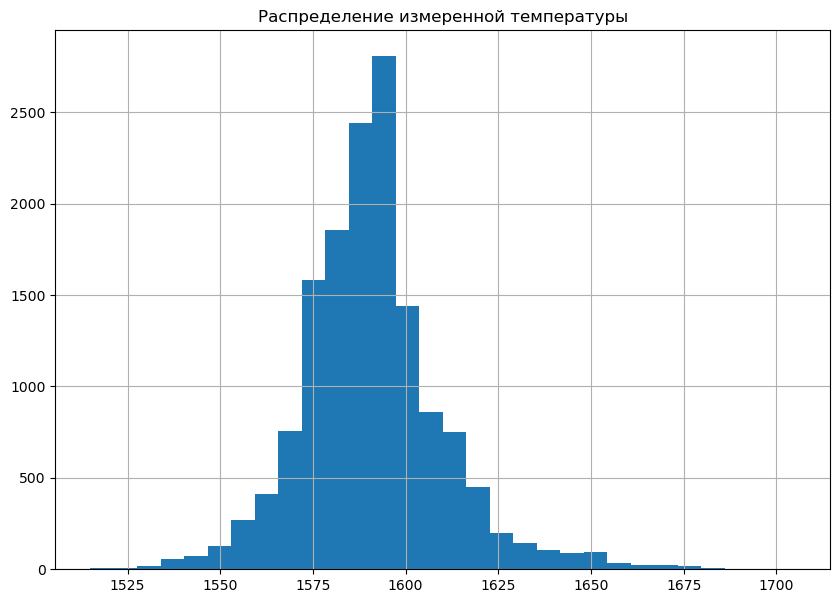

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
df_temp.loc[df_temp.iloc[:, 2] > 1500, 'Температура'].hist(bins=30, ax=ax)
ax.set_title('Распределение измеренной температуры');

In [30]:
# данные о проволочных материалах (объём)
df_wire = pd.read_csv('datasets/data_wire_new.csv', index_col=0)

In [31]:
df_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


In [33]:
df_wire.describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


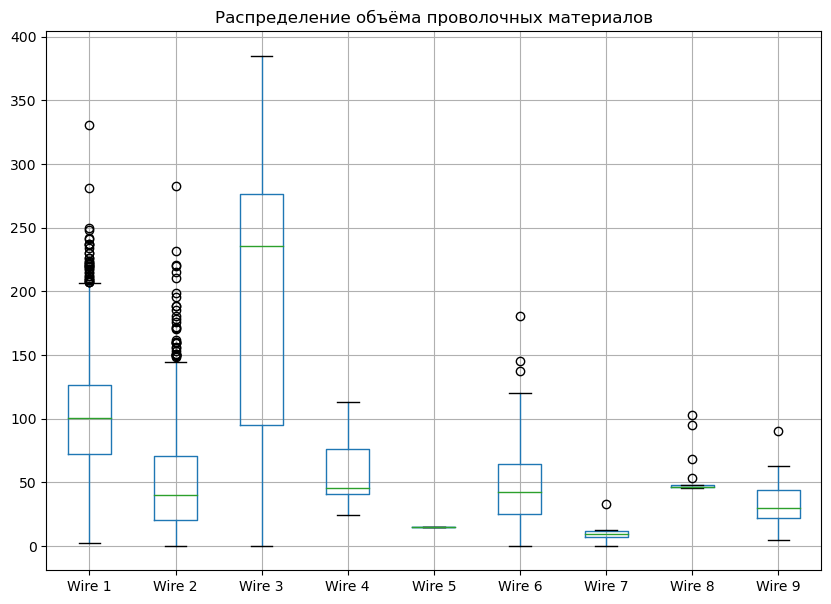

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))
df_wire.boxplot(ax=ax)
ax.set_title('Распределение объёма проволочных материалов');

In [35]:
#данные о проволочных материалах (время)
df_wire_time = pd.read_csv('datasets/data_wire_time_new.csv', parse_dates=list(range(1, 10)), index_col=0)

In [36]:
df_wire_time.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [37]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
 2   Wire 3  63 non-null     datetime64[ns]
 3   Wire 4  14 non-null     datetime64[ns]
 4   Wire 5  1 non-null      datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


In [38]:
df_wire_time.describe(datetime_is_numeric=True)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055,1079,63,14,1,73,11,19,29
mean,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23


In [39]:
df_wire_time.apply(lambda x: x.dropna().is_monotonic_increasing)

Wire 1    True
Wire 2    True
Wire 3    True
Wire 4    True
Wire 5    True
Wire 6    True
Wire 7    True
Wire 8    True
Wire 9    True
dtype: bool

**Выводы по разделу 1:**
- **Данные об электродах.** Ок. 15000 строк, пропусков нет. Временные отметки расположены по возрастанию. Можно использовать их для объединения с другими таблицами, а затем заменить их на столбец с продолжительностью воздействия. Также можно создать столбец с полной мощностью и заменить им два соответствующих. В столбце с реактивной мощностью есть один выброс; считаю, что мощность там указана в других единицах и значение нужно разделить на 1000. Неизвестны единицы измерения мощности.
- **Данные о подаче сыпучих материалов.** 3129 строк - по одной на каждую партию. Много пропусков: скорее всего, пропуск означает, что данный материал не использовался - заполняем пропуски нулями. Названий материалов нет: предположительно, это коммерческая тайна. В данных о материале 12 есть выброс - неестественно большое значение, эту строку удалим. Если материал не использовался - ставим 0. При этом, в некоторых партиях сыпучие материалы не применялись.
- **Данные о продувке сплава газом.** Один столбец, без пропусков и выбросов. Не указана сама величина (наверное, объём) и единицы измерения.
- **Результаты измерения температуры.** Целевой признак. Измерения проводились перед каждой итерацией нагревания. Более 3000 пропусков. Их нужно удалить после объединения с другими таблицами.
- **Данные о проволочных материалах.** Данные о каждой партии. Большое количество пропусков. По-видимому таких материалов используется немного, заполним пропуски нулями. Выбросов нет.


## 2. <a id='toc2_'></a>[План работ по проекту](#toc0_)

1. Провести предобработку данных: обработать пропуски и выбросы, добавить необходимые признаки, объединить таблицы в итоговую.
2. Разработать модель предсказания температуры: опробовать линейную регрессию, случайный лес, градиентный бустинг LightGBM иполносвязную нейросеть.
3. Измерить качество модели на тестовой выборке, изучить значимость признаков, сделать выводы.

## 3. <a id='toc3_'></a>[Вопросы по процессу](#toc0_)

Ответы получены на встрече с "заказчиком" (наставником проекта).
1. Какую метрику качества стоит использовать и какого значения необхдимо достигнуть?
МАЕ <= 6.8.
2. Что более важно: качество предсказания или скорость работы?
Важность примерно одинакова.
3. Модель должна прогнозировать температуру после каждого акта нагревания?
Для каждой партии металла.
4. Как предсказание температуры поможет сэкономить электроэнергию?
Чтобы не нагревать металл до температуры, выше необходимой. Также модель может быть частью другой, более крупной модели.

## 4. <a id='toc4_'></a>[Предобработка данных](#toc0_)

Данные об электродах сгруппируем по номеру партии и выделим следующие признаки: работа эл. тока (время нагревания умножим на активную мощность и просуммируем по всем итерациям данной партии), средняя мощность на электродах.

In [40]:
df_arc['heating_time'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.seconds
df_arc['total_heat'] = df_arc['heating_time'] * df_arc['Активная мощность']

df_arc_upd = pd.pivot_table(df_arc, index='key', values=['total_heat', 'Активная мощность'],
                            aggfunc={'total_heat': 'sum', 'Активная мощность':'mean'})\
                .set_axis(['total_heat', 'mean_power'], axis='columns')

df_arc_upd.head()

,total_heat,mean_power
key,,
1,628.616930,0.607346
2,395.281800,0.534852
3,581.774624,0.812728
4,543.710274,0.676622
5,412.180480,0.563238


В данных о сыпучих веществах удалим выброс, столбцы о редко используемых материалах (1, 2, 5-11, 13) объединим в один, суммируя их объёмы. Пропуски заполняем нулями.

In [41]:
rarely_used_bulks = ['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']

df_bulk_upd = df_bulk.copy() #[df_bulk['Bulk 12'] < 1000].copy()
df_bulk_upd['other_bulks'] = df_bulk_upd[rarely_used_bulks].sum(axis='columns')
df_bulk_upd = df_bulk_upd.drop(columns=rarely_used_bulks).fillna(0)

df_bulk_upd.head()

,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,other_bulks
key,,,,,,
1,0.0,43.0,206.0,150.0,154.0,0.0
2,0.0,73.0,206.0,149.0,154.0,0.0
3,0.0,34.0,205.0,152.0,153.0,0.0
4,0.0,81.0,207.0,153.0,154.0,0.0
5,0.0,78.0,203.0,151.0,152.0,0.0


Из данных о проволочных материалах оставим первый столбец (т.к. этот материал часто используется), остальные - так же сумммируем и заполняем нулями

In [42]:
df_wire_upd = pd.concat([df_wire['Wire 1'].copy(), df_wire.iloc[:, 1:].sum(axis='columns')], axis='columns')\
                .fillna(0).set_axis(['wire_1', 'other_wires'], axis='columns')
df_wire_upd.head()

,wire_1,other_wires
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456


Из данных о измеренной температуре возьмём начальную и конечную температуру партии, последняя - целевой признак. Оставим только те строки, где есть конечная температура.

In [43]:
df_temp_upd = df_temp.fillna(0)\
                     .pivot_table(index='key', values='Температура', aggfunc=['first', 'last'])\
                     .set_axis(['start_temp', 'final_temp'], axis='columns')

df_temp_upd = df_temp_upd.loc[df_temp_upd['final_temp'] != 0]
df_temp_upd.head()

,start_temp,final_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Теперь объединим обработанные таблицы по номеру партии, информация о которых есть во всех таблицах.

In [44]:
df_final = df_arc_upd.merge(df_bulk_upd, how='inner', on='key')\
                     .merge(df_gas, how='inner', on='key')\
                     .merge(df_temp_upd, how='inner', on='key')\
                     .merge(df_wire_upd, how='inner', on='key')\
                     .rename({'Газ 1': 'gas'}, axis='columns')

df_final.head()

,total_heat,mean_power,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,other_bulks,gas,start_temp,final_temp,wire_1,other_wires
key,,,,,,,,,,,,,
1,628.616930,0.607346,0.0,43.0,206.0,150.0,154.0,0.0,29.749986,1571.0,1613.0,60.059998,0.00000
2,395.281800,0.534852,0.0,73.0,206.0,149.0,154.0,0.0,12.555561,1581.0,1602.0,96.052315,0.00000
3,581.774624,0.812728,0.0,34.0,205.0,152.0,153.0,0.0,28.554793,1596.0,1599.0,91.160157,0.00000
4,543.710274,0.676622,0.0,81.0,207.0,153.0,154.0,0.0,18.841219,1601.0,1625.0,89.063515,0.00000
5,412.180480,0.563238,0.0,78.0,203.0,151.0,152.0,0.0,5.413692,1576.0,1602.0,89.238236,9.11456


In [45]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total_heat   2329 non-null   float64
 1   mean_power   2329 non-null   float64
 2   Bulk 3       2329 non-null   float64
 3   Bulk 4       2329 non-null   float64
 4   Bulk 12      2329 non-null   float64
 5   Bulk 14      2329 non-null   float64
 6   Bulk 15      2329 non-null   float64
 7   other_bulks  2329 non-null   float64
 8   gas          2329 non-null   float64
 9   start_temp   2329 non-null   float64
 10  final_temp   2329 non-null   float64
 11  wire_1       2329 non-null   float64
 12  other_wires  2329 non-null   float64
dtypes: float64(13)
memory usage: 254.7 KB


Отделим целевой признак от остальных

In [46]:
features = df_final.drop(columns='final_temp').copy()
target = df_final['final_temp'].copy()
features.shape, target.shape

((2329, 12), (2329,))

Теперь проверим данные на мультиколлинеарность

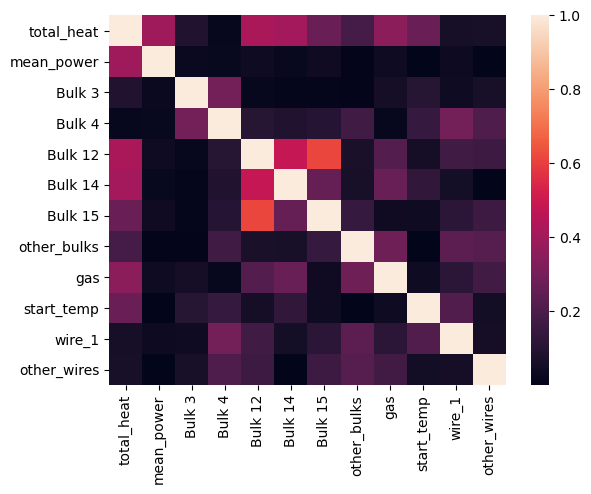

In [47]:
sns.heatmap(features.corr().abs());

Высокой корреляции между признаками не наблюдается.

Теперь разделим данные на трейн-валид и тест в соотношении 3:1.

In [48]:
RANDOM_STATE = 80523
features_train, features_test, target_train, target_test = train_test_split(
                    features, target, test_size=0.25, random_state=RANDOM_STATE)
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((1746, 12), (583, 12), (1746,), (583,))

**Вывод по разделу 2:**
- В данных удалены выбросы, заполнены пропуски, добавлены новые признаки, создана итоговая таблица.
- Данные проверены на мултиколлинеарность: сильной корреляции признаков нет.
- Соззданы обучающая и тестовая выборки.

## 5. <a id='toc5_'></a>[Обучение моделей](#toc0_)

Первоначально обучим модель линейной регрессии.

In [49]:
lr_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                              ('model', LinearRegression())])

params = {'model': [LinearRegression()]}

lr_grid = HalvingGridSearchCV(lr_pipeline, params, scoring='neg_mean_absolute_error',
                                cv=5, verbose=10, n_jobs=-1, random_state=RANDOM_STATE)

In [50]:
%%time
lr_grid.fit(features_train, target_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1746
max_resources_: 1746
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1746
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 93.8 ms
Wall time: 9.17 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', LinearRegression())]),
                    n_jobs=-1, param_grid={'model': [LinearRegression()]},
                    random_state=80523, scoring='neg_mean_absolute_error',
                    verbose=10)

In [51]:
print('Значение MAE, время обучения и время оценки:')
print(pd.DataFrame(lr_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('Лучшее значение MAE:', -lr_grid.best_score_)

Значение MAE, время обучения и время оценки:
   mean_test_score  mean_fit_time  mean_score_time
0         -6.61054       0.019579         0.007341
Лучшее значение MAE: 6.610540298403103


Линейная регрессия обучается за сотые доли секунды  (в Google Colab) и даёт среднее значение МАЕ 6.6.

Теперь обучим случайный лес.

In [52]:
params = {
    'model__max_depth' : [8, 10, 12,15, 20],
    'model__min_samples_split' : [8, 10, 12],
    'model__min_samples_leaf' : [8, 12, 15, 20]
}
rf_pipeline = Pipeline(steps=[('model', RandomForestRegressor(random_state=RANDOM_STATE))])

rf_grid  = HalvingGridSearchCV(rf_pipeline, params, scoring='neg_mean_absolute_error',
                                  cv=3, verbose=3, n_jobs=-1, max_resources=200, factor=3,
                                  resource='model__n_estimators')

In [53]:
%%time
rf_grid.fit(features_train, target_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 7
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 7
Fitting 3 folds for each of 60 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 20
n_resources: 21
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 7
n_resources: 63
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 3
n_candidates: 3
n_resources: 189
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: total: 4.23 s
Wall time: 42.7 s


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('model',
                                               RandomForestRegressor(random_state=80523))]),
                    max_resources=200, n_jobs=-1,
                    param_grid={'model__max_depth': [8, 10, 12, 15, 20],
                                'model__min_samples_leaf': [8, 12, 15, 20],
                                'model__min_samples_split': [8, 10, 12]},
                    resource='model__n_estimators',
                    scoring='neg_mean_absolute_error', verbose=3)

In [54]:
print('Значение MAE, время обучения и время оценки:')
print(pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', rf_grid.best_params_)
print('Лучшее значение MAE:', -rf_grid.best_score_)

Значение MAE, время обучения и время оценки:
    mean_test_score  mean_fit_time  mean_score_time
0         -6.767400       0.330290         0.012528
1         -6.767400       0.270086         0.029739
2         -6.767400       0.268380         0.010492
3         -6.723522       0.291669         0.004614
4         -6.723522       0.239998         0.008609
..              ...            ...              ...
85        -6.641341       1.336328         0.036922
86        -6.641341       1.175219         0.022837
87        -6.638110       4.206690         0.086025
88        -6.638110       4.240221         0.081480
89        -6.638110       3.867729         0.072968

[90 rows x 3 columns]

Лучшие гиперпараметры:
 {'model__max_depth': 10, 'model__min_samples_leaf': 12, 'model__min_samples_split': 8, 'model__n_estimators': 189}
Лучшее значение MAE: 6.6381098725530805


Случайный лес показывает результат МАЕ=6.6, но при этом обучается на порядок дольше - около 1 сек.

Далее - градиентный бустинг.

In [55]:
params = {
    "model__max_depth": [8, 12, 14],
    "model__boosting_type" : ['gbdt'],
    "model__min_child_samples" : [12, 20],
    "model__learning_rate" : [0.005, 0.1, 0.3, 0.4],
    "model__num_leaves": [30, 70, 100]
}
lgbm_pipeline = Pipeline(steps=[('model', LGBMRegressor(random_state=RANDOM_STATE))])

lgbm_grid  = HalvingGridSearchCV(lgbm_pipeline, params, scoring='neg_mean_absolute_error',
                                  cv=3, verbose=3, n_jobs=-1, max_resources=200, factor=3,
                                  resource='model__n_estimators')

In [56]:
%%time
lgbm_grid.fit(features_train, target_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 7
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 7
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 24
n_resources: 21
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 8
n_resources: 63
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 189
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: total: 2.27 s
Wall time: 11.7 s


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('model',
                                               LGBMRegressor(random_state=80523))]),
                    max_resources=200, n_jobs=-1,
                    param_grid={'model__boosting_type': ['gbdt'],
                                'model__learning_rate': [0.005, 0.1, 0.3, 0.4],
                                'model__max_depth': [8, 12, 14],
                                'model__min_child_samples': [12, 20],
                                'model__num_leaves': [30, 70, 100]},
                    resource='model__n_estimators',
                    scoring='neg_mean_absolute_error', verbose=3)

In [57]:
print('Значение MAE, время обучения и время оценки:')
print(pd.DataFrame(lgbm_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', lgbm_grid.best_params_)
print('Лучшее значение MAE:', -lgbm_grid.best_score_)

Значение MAE, время обучения и время оценки:
     mean_test_score  mean_fit_time  mean_score_time
0          -7.886725       0.061717         0.013334
1          -7.877755       0.067291         0.003075
2          -7.877755       0.101469         0.002667
3          -7.887084       0.058012         0.008001
4          -7.884239       0.065997         0.011363
..               ...            ...              ...
102        -7.065063       0.112635         0.010609
103        -7.024302       0.138443         0.007064
104        -7.127170       0.572687         0.029946
105        -7.113460       0.504312         0.029253
106        -7.195813       0.406809         0.033264

[107 rows x 3 columns]

Лучшие гиперпараметры:
 {'model__boosting_type': 'gbdt', 'model__learning_rate': 0.3, 'model__max_depth': 12, 'model__min_child_samples': 12, 'model__num_leaves': 30, 'model__n_estimators': 189}
Лучшее значение MAE: 7.113459520358627


Градиентный бустинг показал себя хуже предыдущих моделей, видимо, для него недостаточно данных.

Также попробуем обучить полносвязную нейросеть.

In [58]:
params = {
    "model__hidden_layer_sizes": [[40], [30, 30], [25, 25, 20]],
    "model__learning_rate_init" : [0.0001, 0.001, 0.005, 0.1],
    "model__activation":  ['relu', 'tanh'],
    "model__solver": ['sgd', 'adam']
    }
nn_pipeline = Pipeline(steps=[('model', MLPRegressor(random_state=RANDOM_STATE))])

nn_grid  = HalvingGridSearchCV(lgbm_pipeline, params, scoring='neg_mean_absolute_error',
                                  cv=3, verbose=3, n_jobs=-1, factor=3,
                                  resource='n_samples')

In [59]:
%%time
nn_grid.fit(features_train, target_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 64
max_resources_: 1746
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 64
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 1
n_candidates: 16
n_resources: 192
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 6
n_resources: 576
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 1728
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 1.27 s
Wall time: 4.45 s


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('model',
                                               LGBMRegressor(random_state=80523))]),
                    n_jobs=-1,
                    param_grid={'model__activation': ['relu', 'tanh'],
                                'model__hidden_layer_sizes': [[40], [30, 30],
                                                              [25, 25, 20]],
                                'model__learning_rate_init': [0.0001, 0.001,
                                                              0.005, 0.1],
                                'model__solver': ['sgd', 'adam']},
                    scoring='neg_mean_absolute_error', verbose=3)

In [60]:
print('Значение MAE, время обучения и время оценки:')
print(pd.DataFrame(nn_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', nn_grid.best_params_)
print('Лучшее значение MAE:', -nn_grid.best_score_)

Значение MAE, время обучения и время оценки:
    mean_test_score  mean_fit_time  mean_score_time
0         -8.282024       0.021338         0.005333
1         -8.282024       0.024790         0.000790
2         -8.282024       0.030919         0.001859
3         -8.282024       0.029070         0.005334
4         -8.282024       0.036368         0.006399
..              ...            ...              ...
67        -7.058012       0.142460         0.008001
68        -7.058012       0.148820         0.005677
69        -7.058012       0.101712         0.005936
70        -6.792053       0.242409         0.029334
71        -6.792053       0.210592         0.014474

[72 rows x 3 columns]

Лучшие гиперпараметры:
 {'model__activation': 'tanh', 'model__hidden_layer_sizes': [25, 25, 20], 'model__learning_rate_init': 0.1, 'model__solver': 'sgd'}
Лучшее значение MAE: 6.792053116620512


Полносвязная нейросеть также показывает низкое качество относительно случайного леса, скорее всего, из-за нехватки данных.

Таким образом, лучшая модель - случайный лес с гиперпараметрами: max_depth = 8, min_samples_leaf = 8, min_samples_split = 8, n_estimators = 200.

**Выводы по разделу 3:**
- Обучены несколько моделей: линейная регрессия, случайный лес, градиентный бустинг, полносвязная нейросеть.
- Выбрана лучшая модель - случайный лес со следующими гиперпараметрами: max_depth = 10, min_samples_leaf = 12, min_samples_split = 8, n_estimators = 200.

|             |Линейная регрессия|Случайный лес|Градиентный бустинг|Полносвязная нейросеть|
|--------------|-----------------|-------------|-------------------|----------------------|
|MAE           |6.6              |6.6          |7.1                |6.7                   |
|Время обучения|0.02             |1.2          |0.2                |0.16                  |



## 6. <a id='toc6_'></a>[Тестирование модели](#toc0_)

Проверим качество лучшей модели на тестовой выборке,предварительно обучив на всем трейне.

In [61]:
final_pipeline = Pipeline(steps=[('model', RandomForestRegressor(max_depth=10, min_samples_leaf=12,
                                                                 min_samples_split=8, n_estimators=200, random_state=RANDOM_STATE))])
final_pipeline.fit(features_train, target_train)
predictions = final_pipeline.predict(features_test)
print('MAE на тестовой выборке:', mean_absolute_error(target_test, predictions))

MAE на тестовой выборке: 6.796069719003394


Итоговая модель показывает значение метрики МАЕ < 6.8 на тесте. 

Изучим теперь важность признаков.

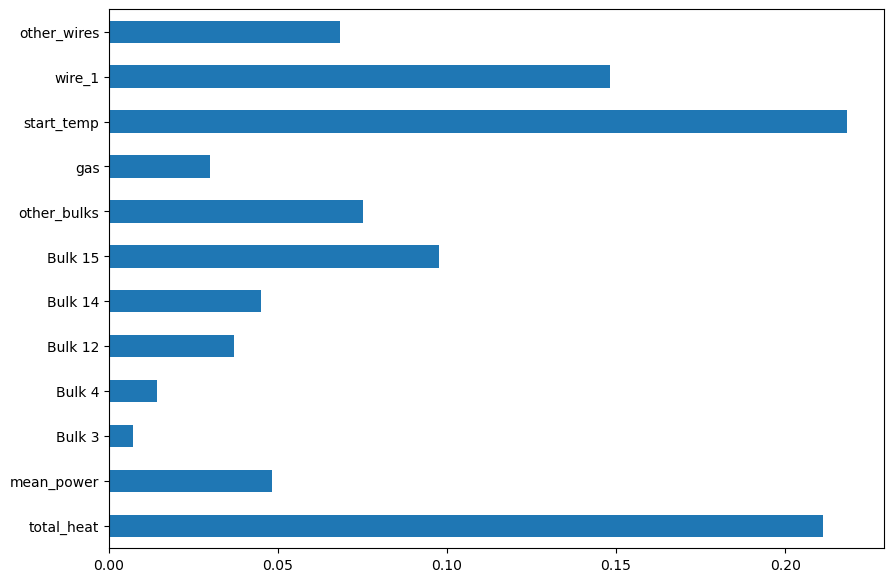

In [62]:
pd.Series(final_pipeline.named_steps['model'].feature_importances_, index=features.columns)\
            .plot(kind='barh', figsize=(10, 7));

Наиболее важные признаки - начальная температура и суммарное количество теплоты при нагреве, что вполне логично.
Также имеется ещё один важный признак: количество проволочного материала 1.
Остальные признаки менее важны. 

## 7. <a id='toc7_'></a>[Отчёт по решению](#toc0_)

1. ***Были выполнены все пункты плана***, в т. ч.:
    1. Проведена предобработа данных: обработаны пропуски и выбросы, добавлены некоторые признаки, таблицы объединены в итоговую.
    2. Разработана модель предсказания температуры: опробованы линейная регрессия, случайный лес, градиентный бустинг LightGBM и полносвязная нейросеть.
    3. Измерено качество модели на тестовой выборке, изучена значимость признаков, сделаны выводы.
<br><br>

2. ***Трудности, возникшие в ходе работы и способы их решения.***
    - При попытке удалить выбросы в данных о легирующих материалах исчезала их существенная часть, для решения этой проблемы модель обучалась на "чистых" данных.
    - Кроме того, те же таблицы содержали большое количество пропусков, здесь малоиспользуемые материалы были объединены в общий столбец.
<br><br>

3. ***Ключевые шаги решения***:
    1. первичный анализ данных;
    2. уточнение информации по данным;
    3. составление плана работ;
    4. предобработка данных;
    5. обучение моделей;
    6. тестирование финальной модели;
    7. написание отчёта о работе.
<br><br>

4. ***Итоговая модель: случайный лес.***
    - Гиперпараметры: max_depth = 8, min_samples_leaf = 8, min_samples_split = 8, n_estimators = 135, random_state = 80523.
    - Значение метрики МАЕ на тестовой выборке: 6.79.
<br><br>

5. ***Признаки, используемые для обучения модели:***
    1. Количество поданных проволочных материалов: материал 1, остальные. Редко используемые материалы (все, кроме №1) объединены в один столбец, при использовании нескольких - просуммированы. Пропуски заполнены нулями, в таких случаях считаем, что соответствующие материалы не использовались.
    2. Сыпучие материалы. Так же, как и в предыдущем пункте, объединены редко используемые материалы (1, 2, 5-11, 13), остальные (3, 4, 12, 14, 15) использовались как отдельные признаки, пропуски заполнены нулями.
    3. Начальная температура. Один из важнейших признаков. Получен из данных об измерениях температуры, дополнительная обработка не проводилась.
    4. Суммарная работа эл. тока. Такой же важный признак. Получен следующим образом: полезная мощность умножена на время работы электродов на каждой итерации нагревания, полученные значения просуммированы для каждой партии металла.
    5. Средняя полезная мощность. Вычислена как среднее арифметическое на каждой партии. 
    6. Объём поданного инертного газа. Данные известны изначально, необходимости в обработке не возникло.
<br><br>

6. ***Для улучшения качества модели можно выполнить следующие действия:***
    - Добавить в модель новые, ранее не исследованные признаки и изучить их влияние на модель. Для этого необходимо проконсультироваться со специалистами по технологическому процессу.
    - Собрать большее количество данных для обучения модели. Тогда возможно лучше себя покажут более "мощные" модели, такие как градиентный бустинг.